In [1]:
import gradio as gr
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

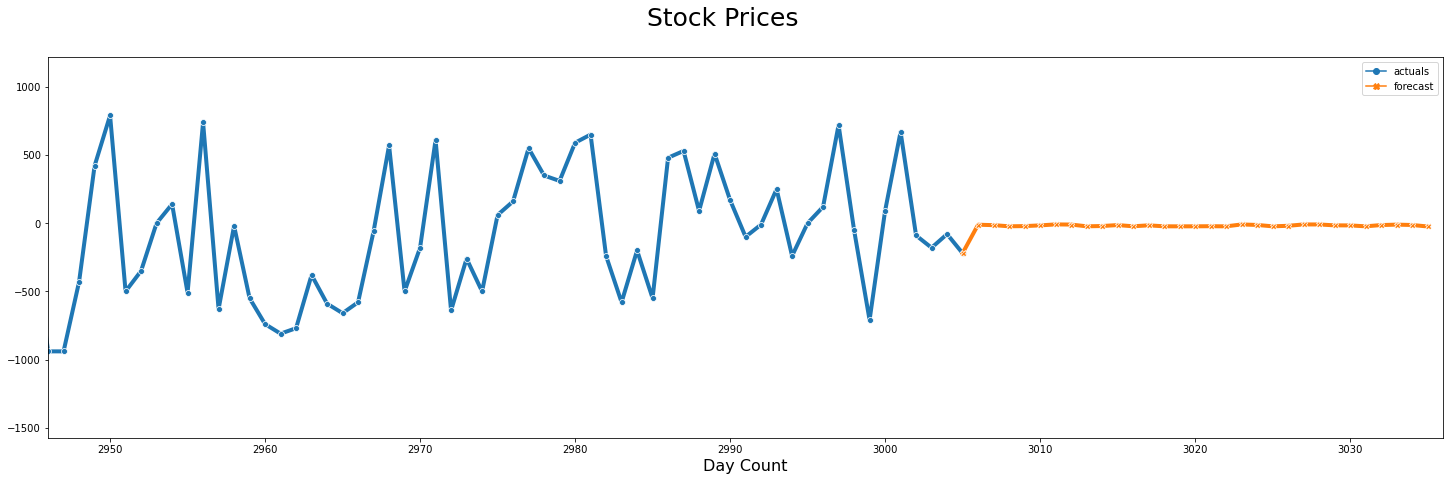

In [12]:
import os
from lightning_models import ForecastLSTM
from utils import train_val_test_split, return_based, returns_direction, log_return_based
import seaborn as sns
import matplotlib.pyplot as plt

def forecast(csvfile):

    df = pd.read_csv(csvfile, index_col=[0])

    model = ForecastLSTM.load_from_checkpoint("lstmpredictor\my_checkpoint.ckpt.ckpt")

    df = pd.read_csv(csvfile, index_col = [0])

    df = df[['<OPEN>','<HIGH>','<LOW>','<CLOSE>','<VOL>']]
    df['<CLOSE>_p'] = pd.DataFrame(return_based(df['<CLOSE>'], 21))
    df['<OPEN>_p'] = pd.DataFrame(return_based(df['<OPEN>'], 21))
    df['<HIGH>_p'] = pd.DataFrame(return_based(df['<HIGH>'], 21))
    df['<LOW>_p'] = pd.DataFrame(return_based(df['<LOW>'], 21))
    df['<VOL>_p'] = pd.DataFrame(log_return_based(df['<VOL>'], 21))
    df['returns'] = pd.DataFrame(returns_direction(df))

    df = df[21:]


    input = df[['<OPEN>_p', '<HIGH>_p', '<LOW>_p', '<CLOSE>_p', '<VOL>_p']][-90:]
    input = model.scaler_X.transform(input)
    input = np.array(input).astype(np.float32)
    input = input.reshape(1, input.shape[0], input.shape[1])

    input = torch.tensor(input)

    model.eval()
    with torch.no_grad():
        
        output = model(torch.tensor(input)) 

    preds = output.squeeze()
    preds = np.array(preds) 

    preds = pd.DataFrame(preds, columns = ['returns'])
    preds[['returns']] = model.scaler_y.inverse_transform(preds[['returns']])

    my_df = pd.DataFrame()

    actuals = df['returns']

    list = [np.nan for i in range(len(df) - 1)]
    list.append(actuals[len(actuals) - 1])

    for i in range(30):
        actuals = actuals.append(pd.Series(pd.NA), ignore_index=True)

    my_df['actuals'] = actuals
    my_df['actuals'] = pd.to_numeric(my_df['actuals'])

    target_series = preds['returns']

    for x in target_series:
        list.append(x)

    my_df['forecast'] = pd.Series(list)
    my_df.loc[len(df) - 1, 'forecast'] = actuals[len(df) - 1]


    fig = plt.figure(figsize=(25, 7))
    sns.lineplot(data = my_df, markers = True, dashes = False, linewidth = 4)
    sns.color_palette("flare", as_cmap=True)
    plt.xlim([len(my_df) - 90, len(my_df)]) #len(my_df) - next_k_days - 10
    fig.suptitle('Stock Prices', fontsize = 25)
    plt.xlabel('Day Count', fontsize = 16)


    return plt

In [13]:
interface = gr.Interface(forecast, 

                            inputs = gr.inputs.Textbox(lines=1, placeholder="Enter csv file path"),

                            outputs = [
                                        gr.Textbox(label = "Company Name", show_label = True),
                                        gr.Plot(label = "Stock Price", visible = True, show_label = True)
                                    ],

                            title = "Ten Days Forecast of Stock Prices",

                            css = """

                                body {background-color : lightblue}

                            """
                        ).launch()

c:\Anaconda\lib\site-packages\gradio\deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
c:\Anaconda\lib\site-packages\gradio\deprecation.py:40: UserWarning: `numeric` parameter is deprecated, and it has no effect
  warnings.warn(value)
c:\Anaconda\lib\site-packages\gradio\deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


Running on local URL:  http://127.0.0.1:7866/

To create a public link, set `share=True` in `launch()`.


C:\Users\YEGYAN~1\AppData\Local\Temp/ipykernel_4836/313658341.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(input))
Traceback (most recent call last):
  File "c:\Anaconda\lib\site-packages\gradio\routes.py", line 275, in predict
    output = await app.blocks.process_api(body, username, session_state)
  File "c:\Anaconda\lib\site-packages\gradio\blocks.py", line 274, in process_api
    predictions = await run_in_threadpool(block_fn.fn, *processed_input)
  File "c:\Anaconda\lib\site-packages\starlette\concurrency.py", line 41, in run_in_threadpool
    return await anyio.to_thread.run_sync(func, *args)
  File "c:\Anaconda\lib\site-packages\anyio\to_thread.py", line 31, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "c:\Anaconda\lib\site-packages\anyio\_backends\_asyncio.py",